In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.utils import shuffle
import statsmodels.api as sm

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Load Dataset with all columns
# Making the data columns datetime objects with the parse_dates attribute
bikeshare_machine = pd.read_csv('/Users/matthewcassi/Documents/Bike-Sharing-Dataset/less_bikeshare_lat_lon.csv', 
                        parse_dates=['Start date', 'End date', 'start_date_short', 'end_date_short'])
# Removing the Unnamed column
bikeshare_machine.drop('Unnamed: 0', 1, inplace=True)

In [4]:
# creating a list of columns which will be used to create the list of columns to keep for the machine
# learning piece
list(bikeshare_machine.columns)

['Start date',
 'End date',
 'start_station',
 'start_station_code',
 'end_station',
 'end_station_code',
 'Member Type',
 'start_date_short',
 'end_date_short',
 'time_diff',
 'season',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'hum',
 'windspeed',
 'start_lat',
 'start_lon',
 'end_lat',
 'end_lon',
 'miles']

In [5]:
# Selecting the columns that are needed for the analysis
included_cols = ['start_station',
                 'end_station',
                 'Member Type',
                 'time_diff',
                 'season',
                 'mnth',
                 'holiday',
                 'weekday',
                 'workingday',
                 'weathersit',
                 'temp',
                 'hum',
                 'windspeed',
                 'miles']
# Subsetting the dataset so that only the columns above are included
bikeshare_machine = bikeshare_machine[included_cols]
bikeshare_machine.head()

,start_station,end_station,Member Type,time_diff,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,miles
0,14th & Harvard St NW,16th & Harvard St NW,Registered,1.833,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.238743
1,Lincoln Park / 13th & East Capitol St NE,13th & H St NE,Registered,3.317,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.659533
2,14th & R St NW,Massachusetts Ave & Dupont Circle NW,Registered,5.733,2,3,0,4,1,3,0.268333,0.918333,0.217646,0.691996
3,Park Rd & Holmead Pl NW,15th & P St NW,Registered,8.700,2,3,0,4,1,3,0.268333,0.918333,0.217646,1.453796
4,37th & O St NW / Georgetown University,21st & M St NW,Registered,7.850,2,3,0,4,1,3,0.268333,0.918333,0.217646,1.351053


In [6]:
# Make categorical data for columns like month, holiday, etc.
bikeshare_machine['season'] = bikeshare_machine['season'].astype('category')
bikeshare_machine['mnth'] = bikeshare_machine['mnth'].astype('category')
bikeshare_machine['holiday'] = bikeshare_machine['holiday'].astype('category')
bikeshare_machine['weekday'] = bikeshare_machine['weekday'].astype('category')
bikeshare_machine['workingday'] = bikeshare_machine['workingday'].astype('category')
bikeshare_machine['weathersit'] = bikeshare_machine['weathersit'].astype('category')
bikeshare_machine['Member Type'] = bikeshare_machine['Member Type'].astype('category')
bikeshare_machine['start_station'] = bikeshare_machine['start_station'].astype('category')
bikeshare_machine['end_station'] = bikeshare_machine['end_station'].astype('category')

In [7]:
# Update columns names for the dataset
col_names = ['start_station', 'end_station','member_type','time_diff','season','month','holiday',
             'weekday','work_day','weather_cat','temperature','humidity','windspeed','miles']
bikeshare_machine.columns = col_names

In [8]:
# Standardization of windspeed, humidity, and temperature were not all the same
# Values were changed back to their original values (not scaled)
tmin = -8
tmax = 39
hum_max = 100
wind_max = 67
bikeshare_machine['temp'] = bikeshare_machine['temperature'] * (tmax - tmin) + tmin
bikeshare_machine['hum'] = bikeshare_machine['humidity'] * 100
bikeshare_machine['wind'] = bikeshare_machine['windspeed'] * 67

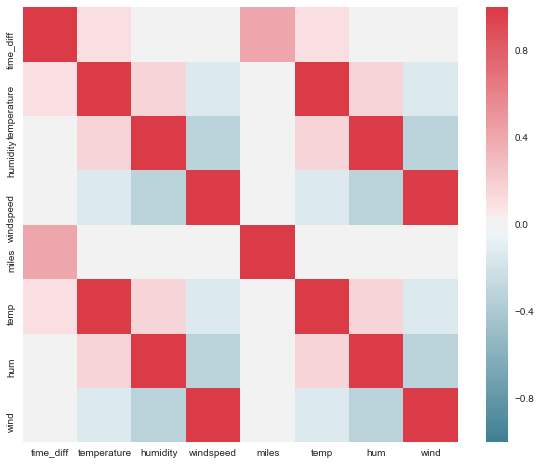

In [9]:
# Checking the correlations between continuous variables
corr = bikeshare_machine.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [10]:
# Turn categorical data into dummy variables. Dropping first dummy for the category variables that have 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['member_type','holiday','work_day'], drop_first=True)
# Turning categorical data into dummy variables. Not dropping the first dummy for categorical data with more
# than 2 labels
bikeshare_machine = pd.get_dummies(bikeshare_machine, 
                                 columns=['start_station','end_station','season','month','weekday','weather_cat'])
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,miles,temp,hum,wind,member_type_Registered,holiday_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
0,1.833,0.268333,0.918333,0.217646,0.238743,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
1,3.317,0.268333,0.918333,0.217646,0.659533,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
2,5.733,0.268333,0.918333,0.217646,0.691996,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
3,8.700,0.268333,0.918333,0.217646,1.453796,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1
4,7.850,0.268333,0.918333,0.217646,1.351053,4.611651,91.8333,14.582282,1,0,...,0,0,0,0,1,0,0,0,0,1


In [11]:
bikeshare_machine = shuffle(bikeshare_machine)
bikeshare_machine.head()

,time_diff,temperature,humidity,windspeed,miles,temp,hum,wind,member_type_Registered,holiday_1,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_cat_1,weather_cat_2,weather_cat_3
956284,4.433,0.337500,0.465000,0.191542,0.656648,7.862500,46.5000,12.833314,1,0,...,1,0,0,0,0,0,0,1,0,0
857116,8.183,0.484167,0.720417,0.148642,0.691996,14.755849,72.0417,9.959014,1,0,...,0,0,0,1,0,0,0,0,1,0
431593,20.100,0.595000,0.900000,0.096404,1.442518,19.965000,90.0000,6.459081,1,0,...,0,0,0,1,0,0,0,0,1,0
356579,16.167,0.459167,0.407083,0.325258,0.334336,13.580849,40.7083,21.792286,1,0,...,0,0,0,0,1,0,0,1,0,0
203738,1.533,0.707500,0.597917,0.187808,0.238743,25.252500,59.7917,12.583136,1,0,...,0,0,1,0,0,0,0,1,0,0


### Model 1 - Remove Some Variables that are correlated

In [12]:
# Remove Lasso Columns while including all of the start/end stations
remove_cols = ['weekday_0','time_diff']
X1 = np.matrix(bikeshare_machine.drop(remove_cols, 1))
y1 = bikeshare_machine['time_diff']

In [13]:
# Split the data into training and testing sets and check the shape
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.25, random_state=17)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((914885, 297), (304962, 297), (914885,), (304962,))

In [14]:
# Fit model
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
pred1 = model1.predict(X1_test)
cvscores_model1 = cross_val_score(model1, X1_train, y1_train, cv=5)
model1_r = model1.score(X1_test, y1_test)
model1_mse = mean_squared_error(y1_test, pred1)
model1_rmse = np.sqrt(model1_mse)
adjustedr1 = 1 - (1-model1_r)*(len(y1_test)-1)/(len(y1_test)-X1_test.shape[1]-1)

In [16]:
cvscores_model1, model1_r, adjustedr1, model1_mse, model1_rmse

(array([ -2.94874484e+00,   4.12102431e-01,   4.11256669e-01,
         -4.47943158e+02,   4.16922668e-01]),
 0.41430394812167276,
 0.41373298559440386,
 80.479747758705457,
 8.9710505381870114)

In [17]:
model1_sm = sm.OLS(y1_train, X1_train).fit()
model1_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              time_diff   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     2246.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:17:58   Log-Likelihood:            -3.3037e+06
No. Observations:              914885   AIC:                         6.608e+06
Df Residuals:                  914596   BIC:                         6.611e+06
Df Model:                         288                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.3589      0.035    123.218      0.000       4.290       4.428
x2         -5.111e-05   1.01e-05     -5.059      0.000   -7.09e-05   -3.13e-05
x3            -0.0003   3.12e-05     -8.848      0.000      -0.000      -0.000
x4             6.1430      0.013    459.197      0.000       6.117       6.169
x5            -0.0352      0.003    -11.541      0.000      -0.041      -0.029
x6            -0.0051      0.001     -5.059      0.000      -0.007      -0.003
x7            -0.0185      0.002     -8.848      0.000      -0.023      -0.014
x8           -11.3561      0.027   -413.529      0.000     -11.410     -11.302
x9            -0.3026      0.059     -5.154      0.000      -0.418      -0.188
x10           -1.2880      0.023    -55.104      0.000      -1.334      -1.242
x11           -1.1140      0.215     -5.172      0.000      -1.536      -0.692
x12           -1.2688      0.113    -11.258      0.000      -1.490      -1.048
x13            3.4320      0.116     29.515      0.000       3.204       3.660
x14           -1.1660      0.245     -4.752      0.000      -1.647      -0.685
x15           -2.0391      0.117    -17.414      0.000      -2.269      -1.810
x16            1.5405      0.312      4.944      0.000       0.930       2.151
x17           -0.4924      0.326     -1.510      0.131      -1.132       0.147
x18           -1.9184      0.124    -15.478      0.000      -2.161      -1.675
x19           -1.1057      0.125     -8.873      0.000      -1.350      -0.861
x20            0.1798      0.118      1.521      0.128      -0.052       0.411
x21            3.0594      0.131     23.399      0.000       2.803       3.316
x22           -1.1862      0.138     -8.621      0.000      -1.456      -0.917
x23            1.0566      0.121      8.733      0.000       0.819       1.294
x24           -2.5810      0.111    -23.314      0.000      -2.798      -2.364
x25           -1.4677      0.114    -12.924      0.000      -1.690      -1.245
x26           -0.9280      0.106     -8.775      0.000      -1.135      -0.721
x27           -1.5257      0.103    -14.789      0.000      -1.728      -1.323
x28           -2.4113      0.141    -17.108      0.000      -2.688      -2.135
x29           -1.9838      0.225     -8.808      0.000      -2.425      -1.542
x30            3.1397      0.231     13.571      0.000       2.686       3.593
x31           -0.5578      0.100     -5.581      0.000      -0.754      -0.362
x32           -2.0354      0.278     -7.332      0.000      -2.580      -1.491
x33           -2.3134      0.109    -21.276      0.000      -2.526      -2.100
x34           -0.8288      0.102     -8.110      0.000      -1.029      -0.629
x35            0.1204      0.126      0.954      0.340      -0.127       0.368
x36           -0.5393      0.112     -4.815      0.000      -0.759      -0.320
x3

### Model 4 - Ridge with Round 1

In [18]:
# Fit the model with 5 folds
alpha = np.arange(0.0001, 20, 25)
param_grid = {'alpha': alpha}
ridge1 = Ridge(fit_intercept=True)
ridge1_gs = GridSearchCV(ridge1, param_grid, cv=5)
ridge1_gs.fit(X1_train, y1_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.0001])}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [19]:
pred4 = ridge1_gs.predict(X1_test)
ridge1_r = ridge1_gs.score(X1_test, y1_test)
ridge1_mse = mean_squared_error(y1_test, pred4)
ridge1_rmse = np.sqrt(ridge1_mse)
adjustedr4 = 1 - (1-ridge1_r)*(len(y1_test)-1)/(len(y1_test)-X1_test.shape[1]-1)

In [20]:
ridge1_r, ridge1_mse, ridge1_rmse, adjustedr4

(0.41430397658432738,
 80.479743847688397,
 8.9710503202071266,
 0.41373301408480512)